In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

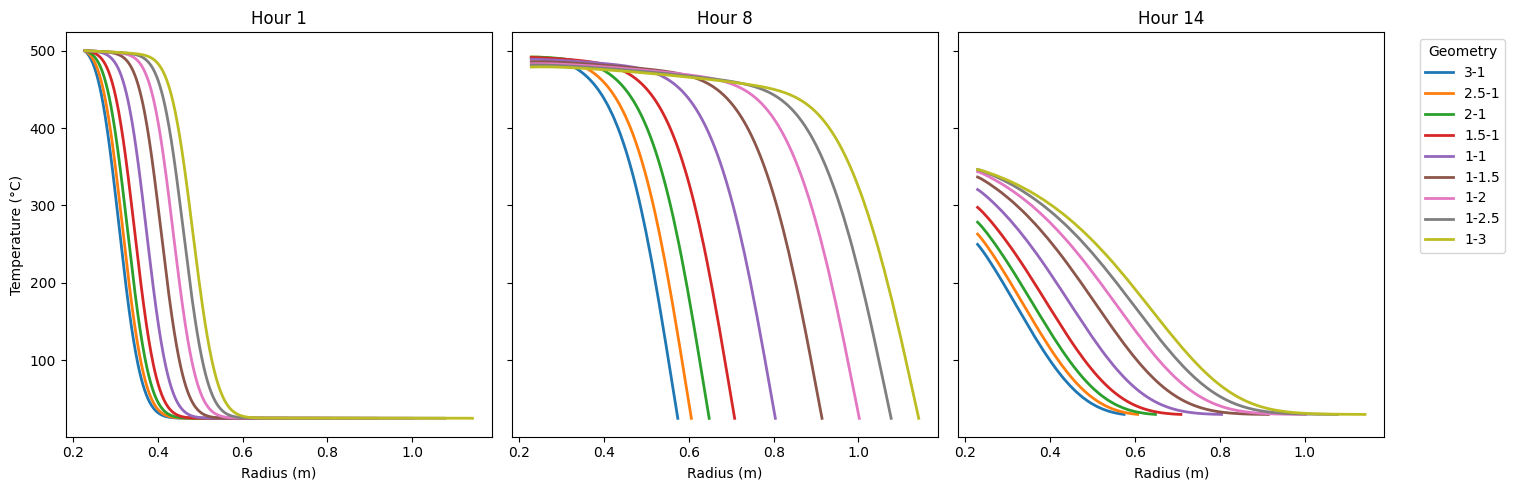

In [3]:

BASE_DIR   = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\official"
PROFILES   = "thermocline_profiles.csv"

#——— manually list exactly the geometries you have ———
SUBDIRS = [
    "3-1",
    "2.5-1",
    "2-1",
    "1.5-1",
    "1-1",
    "1-1.5",
    "1-2",
    "1-2.5",
    "1-3",
]

# which hours/phases to snapshot?
TRACE_HOURS = [1, 8, 14]
PHASE_IDX   = [h-1 for h in TRACE_HOURS]

# pick a distinct color for each
palette = plt.get_cmap("tab10")
colors  = {geo: palette(i%10) for i, geo in enumerate(SUBDIRS)}

# load all CSVs
all_data = {}
for geo in SUBDIRS:
    path = os.path.join(BASE_DIR, geo, PROFILES)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {PROFILES} in folder {geo}")
    all_data[geo] = pd.read_csv(path)

# build 1×3 panel
fig, axs = plt.subplots(1, len(TRACE_HOURS), figsize=(5*len(TRACE_HOURS),5), sharey=True)

for ax, hour, phase in zip(axs, TRACE_HOURS, PHASE_IDX):
    for geo, df in all_data.items():
        dfp = df[df["Phase"] == phase]
        ax.plot(dfp["Radius_m"], dfp["Temperature_C"],
                color=colors[geo], lw=2, label=geo)
    ax.set_title(f"Hour {hour}")
    ax.set_xlabel("Radius (m)")

axs[0].set_ylabel("Temperature (°C)")
axs[-1].legend(title="Geometry", loc="upper right", bbox_to_anchor=(1.3,1))
plt.tight_layout()
plt.show()


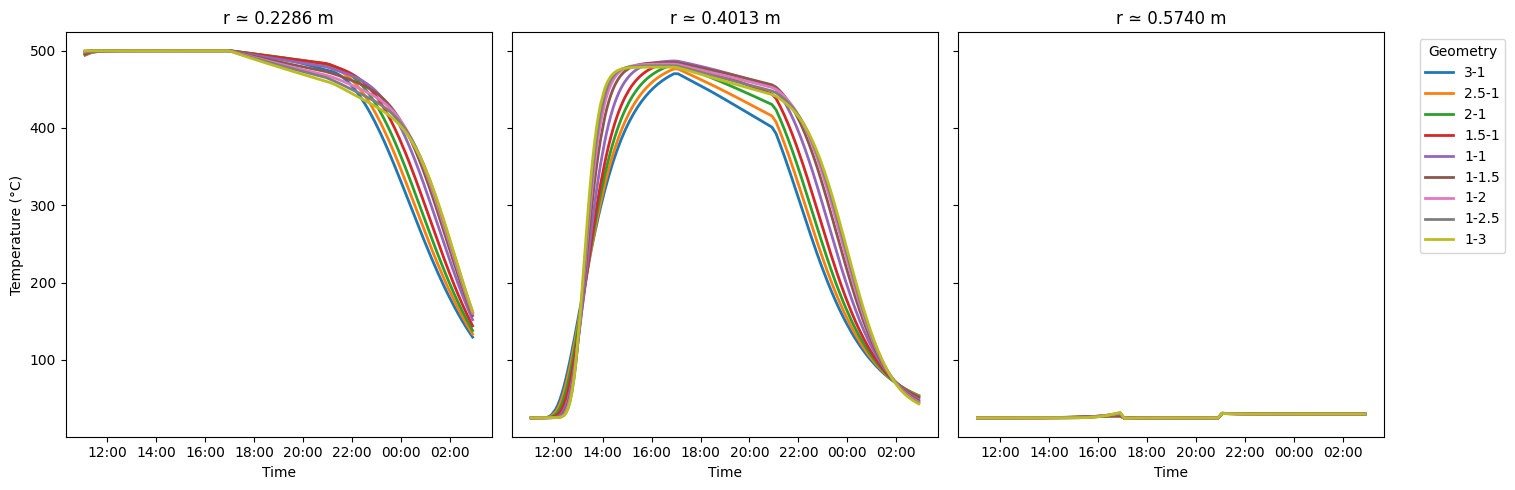

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# ── CONFIG ─────────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\official"
GEOMETRIES  = [
    "3-1",
    "2.5-1",
    "2-1",
    "1.5-1",
    "1-1",
    "1-1.5",
    "1-2",
    "1-2.5",
    "1-3",
]
HISTORY_CSV = "thermocline_timehistory.csv"

# physical radial domain (same for all sims)
R_IN  = 0.2286
R_OUT = 0.574
# your three radii of interest
R_TARGS = [R_IN, 0.5*(R_IN + R_OUT), R_OUT]

# build the nodal‐radius array once (they said ~1000 pts)
# we'll infer N by loading one CSV
sample = pd.read_csv(os.path.join(BASE_DIR, GEOMETRIES[0], HISTORY_CSV))
Ts_cols = sorted([c for c in sample.columns if c.startswith("Ts_r")],
                 key=lambda c: int(c.split("Ts_r")[1]))
N = len(Ts_cols)
r_nodes = np.linspace(R_IN, R_OUT, N)

# find the three indices nearest to your targets
idxs = [np.abs(r_nodes - r).argmin() for r in R_TARGS]

# anchor time for plotting
BASE_TIME = datetime(2033, 3, 20, 11, 0, 0)

# ── PLOT ────────────────────────────────────────────────────────────────────
fig, axs = plt.subplots(1, len(R_TARGS), figsize=(15, 5), sharey=True)
for ax, r in zip(axs, R_TARGS):
    ax.set_title(f"r ≃ {r:.4f} m")
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].set_ylabel("Temperature (°C)")

for geom in GEOMETRIES:
    fn = os.path.join(BASE_DIR, geom, HISTORY_CSV)
    if not os.path.exists(fn):
        print(f"skipping {geom!r} (no file)")
        continue

    df = pd.read_csv(fn)
    df = df[df["time_sec"] > 0].copy()
    df["time_dt"] = df["time_sec"].apply(
        lambda s: BASE_TIME + timedelta(seconds=s)
    )

    Ts_arr = df[Ts_cols].values  # shape (time, N)

    # plot each of the three radii on its own axis
    for ax, idx in zip(axs, idxs):
        ax.plot(
            df["time_dt"],
            Ts_arr[:, idx] - 273.15,  # drop 273.15 if your CSV is °C already
            lw=2,
            label=geom
        )

axs[-1].legend(title="Geometry", loc="upper right", bbox_to_anchor=(1.3, 1))
for ax in axs:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()


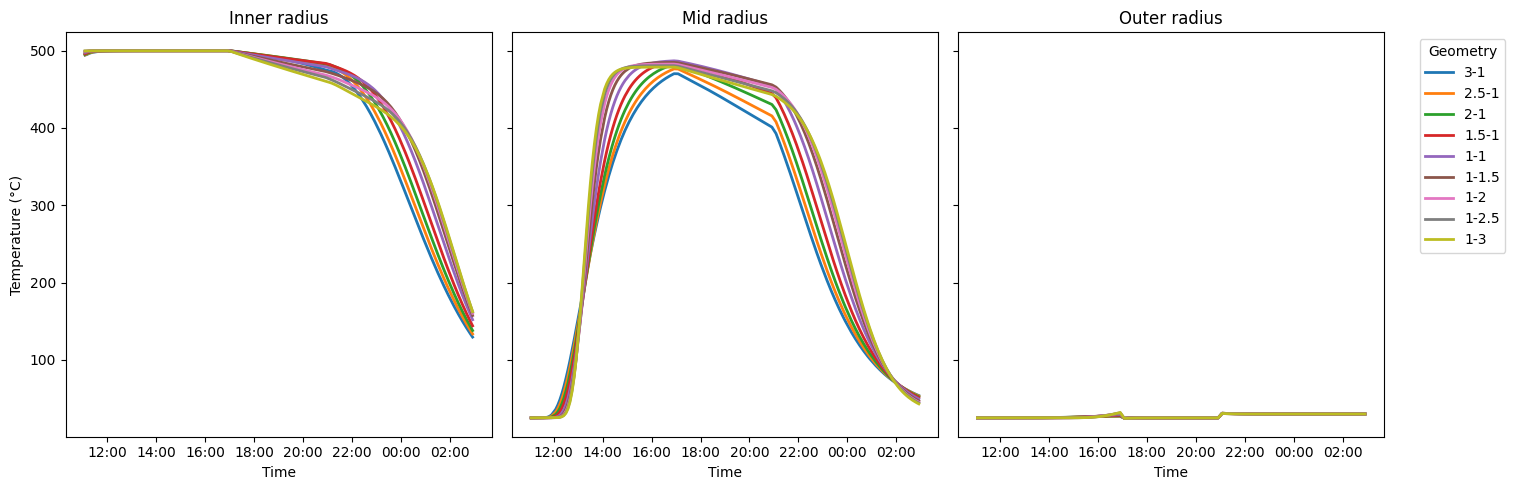

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# ── CONFIG ─────────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\official"
GEOMETRIES  = [
    "3-1",
    "2.5-1",
    "2-1",
    "1.5-1",
    "1-1",
    "1-1.5",
    "1-2",
    "1-2.5",
    "1-3",
]
HISTORY_CSV = "thermocline_timehistory.csv"
BASE_TIME   = datetime(2033,3,20,11,0,0)

# ——— geometry parameters ———
rL = 0.2286   # common inner radius for all
geom_params = {
    "3-1":      {"rR": 0.574,  "B": 1.721},
    "2.5-1":{"rR": 0.606,  "B": 1.515},
    "2-1":      {"rR": 0.648,  "B": 1.296},
    "1.5-1":{"rR": 0.708,  "B": 1.062},
    "1-1":      {"rR": 0.804,  "B": 0.804},
    "1-1.5":{"rR": 0.914,  "B": 0.609},
    "1-2":      {"rR": 1.0019,"B": 0.501},
    "1-2.5":{"rR": 1.077,  "B": 0.431},
    "1-3":      {"rR": 1.142,  "B": 0.381},
}

# ── SET UP FIGURE ───────────────────────────────────────────────────────────
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
for ax, title in zip(axs, ("Inner radius", "Mid radius", "Outer radius")):
    ax.set_title(title)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].set_ylabel("Temperature (°C)")

# ── LOOP OVER GEOMETRIES ────────────────────────────────────────────────────
for geom in GEOMETRIES:
    fn = os.path.join(BASE_DIR, geom, HISTORY_CSV)
    if not os.path.exists(fn):
        print(f"skipping {geom!r} (no CSV)")
        continue

    # load + timestamp
    df = pd.read_csv(fn)
    df = df[df["time_sec"] > 0].copy()
    df["time_dt"] = df["time_sec"].apply(
        lambda s: BASE_TIME + timedelta(seconds=s)
    )

    # build that sim’s nodal radii (1000 points from rL to rR)
    rR = geom_params[geom]["rR"]
    N  = len([c for c in df.columns if c.startswith("Ts_r")])
    r_nodes = np.linspace(rL, rR, N)

    # pick the three “true” radii
    r_targets = [rL, 0.5*(rL + rR), rR]
    idxs = [np.abs(r_nodes - r).argmin() for r in r_targets]

    # extract temperature array
    Ts_cols = sorted([c for c in df.columns if c.startswith("Ts_r")],
                     key=lambda c: int(c.split("Ts_r")[1]))
    Ts_arr = df[Ts_cols].values  # shape (time, N)

    # plot inner, mid, outer on the three axes
    for ax, idx in zip(axs, idxs):
        ax.plot(
            df["time_dt"],
            Ts_arr[:, idx] - 273.15,  # drop “-273.15” if CSV already in °C
            lw=2,
            label=geom
        )

# ── FINISH UP ───────────────────────────────────────────────────────────────
axs[-1].legend(title="Geometry", loc="upper right", bbox_to_anchor=(1.3,1))
for ax in axs:
    ax.set_xlabel("Time")

plt.tight_layout()
plt.show()


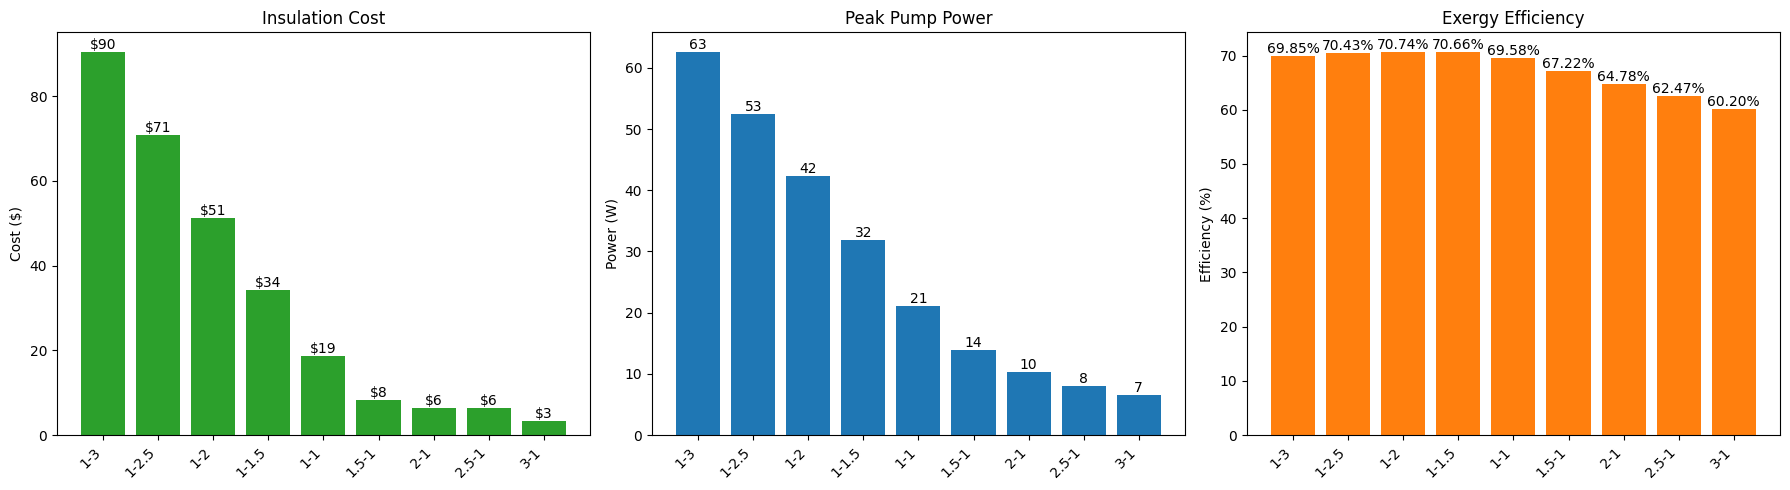

In [38]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ── CONFIG ─────────────────────────────────────────────────────────────────
BASE_DIR    = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\official"
GEOMs       = [
    "1-3","1-2.5","1-2","1-1.5","1-1","1.5-1","2-1","2.5-1","3-1",
]
SUMMARY_CSV = "geometry_summary.csv"

hole_radius = 0.0254   # m
unit_cost   = 58.5     # $/m³ super-wool

# outer‐radius lookup (m)
r_map = {
    "1-3":   1.1469,
    "1-2.5": 1.0840,
    "1-2":   1.0019,
    "1-1.5": 0.914,
    "1-1":   0.7952,
    "1.5-1": 0.6312,
    "2-1":   0.6300,
    "2.5-1": 0.6950,
    "3-1":   0.5510,
}

# ── GATHER DATA ────────────────────────────────────────────────────────────
costs, effs, pumps_kW = [], [], []

for geom in GEOMs:
    df = pd.read_csv(os.path.join(BASE_DIR, geom, SUMMARY_CSV))
    ins_m = df.loc[0, "Insulation_m"]
    eta   = df.loc[0, "Eta exergy"]
    pump  = df.loc[0, "Max Pumping Power [kW]"]

    # compute insulation cost
    Rout      = r_map[geom]
    tank_area = np.pi*Rout**2 - np.pi*hole_radius**2
    cost      = ins_m * tank_area * unit_cost

    costs   .append(cost)
    effs    .append(eta*1)
    pumps_kW.append(pump)

# convert to W
pumps_W = [p*1e3 for p in pumps_kW]

# ── PLOT ───────────────────────────────────────────────────────────────────
x = np.arange(len(GEOMs))
fig, axs = plt.subplots(1,3, figsize=(18,5), sharex=True)

# Insulation Cost
axs[0].bar(x, costs, color='C2')
axs[0].set_title("Insulation Cost"); axs[0].set_ylabel("Cost ($)")
axs[0].set_xticks(x); axs[0].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi,c in zip(x,costs):
    axs[0].text(xi, c, f"${c:.0f}", ha="center", va="bottom")

# Exergy Efficiency
axs[2].bar(x, effs, color='C1')
axs[2].set_title("Exergy Efficiency"); axs[2].set_ylabel("Efficiency (%)")
axs[2].set_xticks(x); axs[2].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi,e in zip(x,effs):
    axs[2].text(xi, e, f"{e:.2f}%", ha="center", va="bottom")

# Peak Pump Power (W)
axs[1].bar(x, pumps_W, color='C0')
axs[1].set_title("Peak Pump Power"); axs[1].set_ylabel("Power (W)")
axs[1].set_xticks(x); axs[1].set_xticklabels(GEOMs, rotation=45, ha="right")
for xi,p in zip(x,pumps_W):
    axs[1].text(xi, p, f"{p:.0f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()


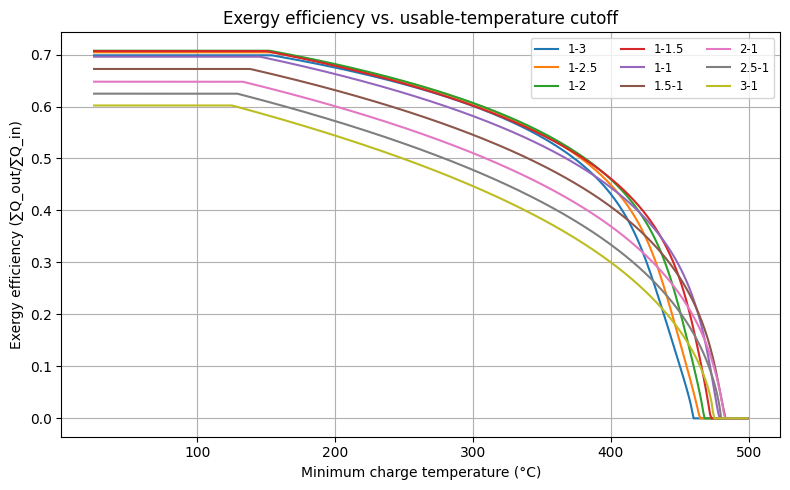

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Settings — adjust to your own paths
BASE_DIR = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\official"
GEOMs = ["1-3","1-2.5","1-2","1-1.5","1-1","1.5-1","2-1","2.5-1","3-1"]
THRESHOLDS = np.arange(25, 500)  # 25°C through 249°C

# 2) Prepare a DataFrame to hold every geometry’s efficiency curve
eff_df = pd.DataFrame(index=THRESHOLDS, columns=GEOMs, dtype=float)

# 3) Loop through each geometry
for geom in GEOMs:
    folder = os.path.join(BASE_DIR, geom)
    csv_path = os.path.join(folder, "exergy_history.csv")
    
    # read your per‐phase history
    df = pd.read_csv(csv_path)
    gas_temp = df["Gas Temp (C)"].to_numpy()
    q_in     = df["Energy_Charged_kWh"].to_numpy()
    q_out    = df["Energy_Discharged_kWh"].to_numpy()
    
    # compute efficiency curve
    effs = []
    for T_th in THRESHOLDS:
        mask = gas_temp >= T_th
        Qc = q_in[mask].sum()
        Qd = q_out[mask].sum()
        effs.append(Qd/Qc if Qc>0 else np.nan)
    
    eff_df[geom] = effs

# 4) (Optional) Save to disk
eff_df.to_csv(os.path.join(BASE_DIR, "exergy_efficiency_all_geoms.csv"))

# 5) Plot them all together


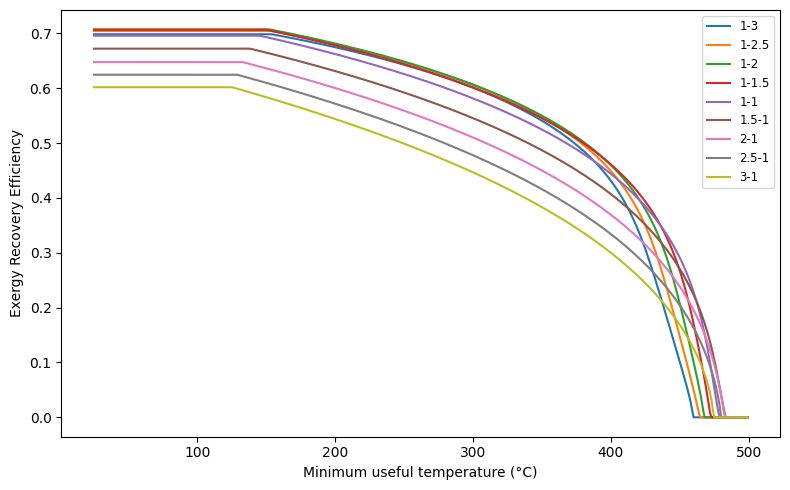

In [28]:
plt.figure(figsize=(8,5))
for geom in GEOMs:
    plt.plot(THRESHOLDS, eff_df[geom], label=geom)
plt.xlabel("Minimum useful temperature (°C)")
plt.ylabel("Exergy Recovery Efficiency")
plt.legend(ncol=1, fontsize="small")
# plt.grid(True)
plt.tight_layout()
plt.show()

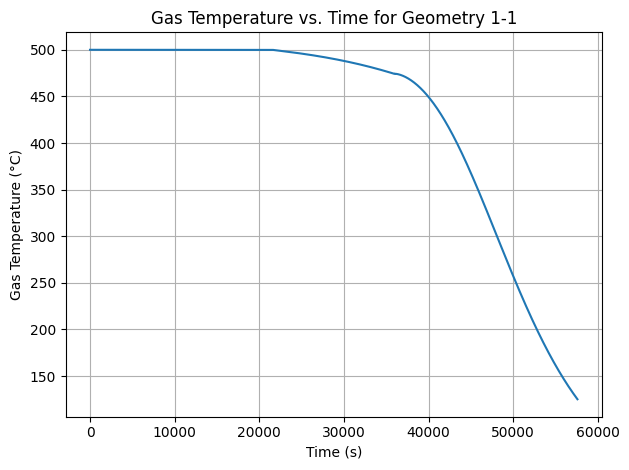

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Paths
BASE_DIR = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\official"
geom = "3-1"
csv_path = os.path.join(BASE_DIR, geom, "exergy_history.csv")

# Load data
df = pd.read_csv(csv_path)
time_sec = df["SimTime_sec"].to_numpy()
gas_temp_C = df["Gas Temp (C)"].to_numpy()

# Plot
plt.figure()
plt.plot(time_sec, gas_temp_C)
plt.xlabel("Time (s)")
plt.ylabel("Gas Temperature (°C)")
plt.title("Gas Temperature vs. Time for Geometry 1-1")
plt.grid(True)
plt.tight_layout()
plt.show()


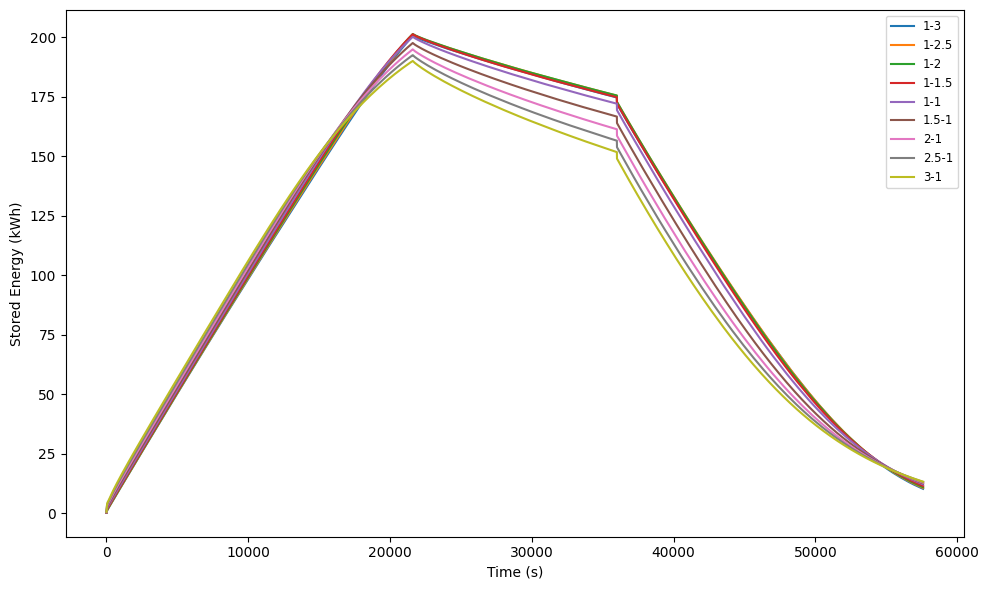

In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Settings
BASE_DIR = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\official"
GEOMs = ["1-3","1-2.5","1-2","1-1.5","1-1","1.5-1","2-1","2.5-1","3-1"]

# Figure setup
fig, ax = plt.subplots(figsize=(10, 6))

# Downsampling parameters
chunksize = 10**6       # rows per chunk
downsample_factor = 100 # take every 100th row in each chunk

# Loop geometries
for geom in GEOMs:
    csv_path = os.path.join(BASE_DIR, geom, "exergy_history.csv")
    time_accum = []
    energy_accum = []
    
    # Read only needed columns in chunks
    for chunk in pd.read_csv(
        csv_path,
        usecols=["SimTime_sec", "Stored_Energy_kWh"],
        dtype={"SimTime_sec": np.float32, "Stored_Energy_kWh": np.float32},
        chunksize=chunksize
    ):
        # downsample within the chunk
        ds = chunk.iloc[::downsample_factor]
        time_accum.append(ds["SimTime_sec"].to_numpy())
        energy_accum.append(ds["Stored_Energy_kWh"].to_numpy())
    
    # concatenate downsampled segments
    time_arr = np.concatenate(time_accum)
    energy_arr = np.concatenate(energy_accum)
    
    # plot
    ax.plot(time_arr, energy_arr, label=geom)

# Finalize plot
ax.set_xlabel("Time (s)")
ax.set_ylabel("Stored Energy (kWh)")
# ax.set_title("Stored Energy vs. Time (downsampled) for All Geometries")
ax.legend(ncol=1, fontsize="small")
# ax.grid(True)
plt.tight_layout()
plt.show()


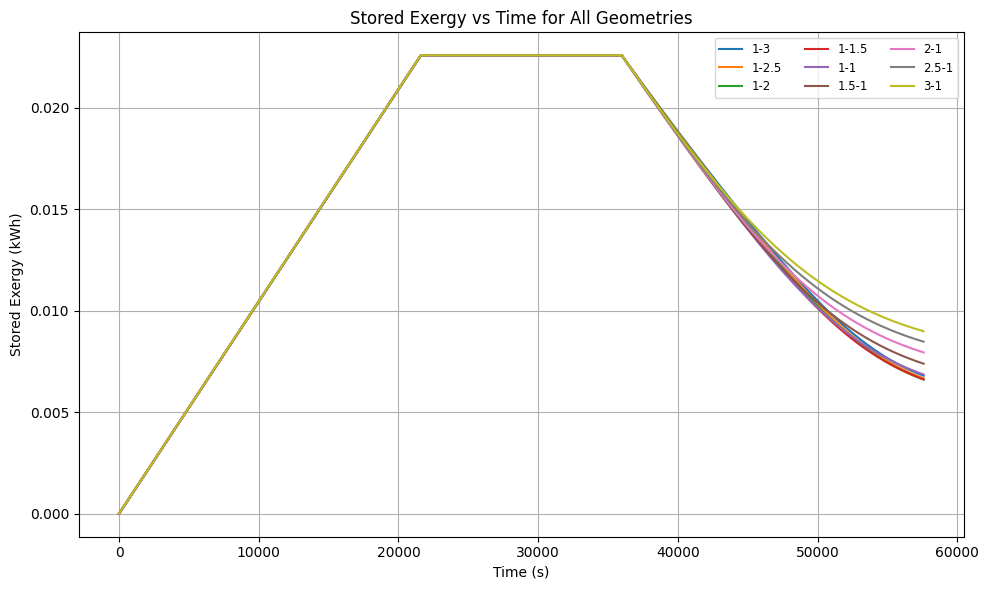

In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Settings
BASE_DIR = r"C:\Users\tljohn\Desktop\RPB Micmaq\geometry simulations\official"
GEOMs = ["1-3","1-2.5","1-2","1-1.5","1-1","1.5-1","2-1","2.5-1","3-1"]

# Downsampling settings
chunksize = 1_000_000       # rows per chunk
downsample = 10000            # take every 100th row

# Prepare plot
fig, ax = plt.subplots(figsize=(10, 6))

# Loop through each geometry
for geom in GEOMs:
    csv_path = os.path.join(BASE_DIR, geom, "exergy_history.csv")
    
    time_accum = []
    charge_ex_accum = []
    discharge_ex_accum = []
    
    # Read in chunks, only exergy columns
    for chunk in pd.read_csv(
        csv_path,
        usecols=["SimTime_sec", "Charge_Exergy_kWh", "Discharge_Exergy_kWh"],
        dtype={"SimTime_sec": np.float32, "Charge_Exergy_kWh": np.float32, "Discharge_Exergy_kWh": np.float32},
        chunksize=chunksize
    ):
        ds = chunk.iloc[::downsample]
        time_accum.append(ds["SimTime_sec"].to_numpy())
        charge_ex_accum.append(ds["Charge_Exergy_kWh"].to_numpy())
        discharge_ex_accum.append(ds["Discharge_Exergy_kWh"].to_numpy())
    
    # Concatenate and compute net stored exergy
    t = np.concatenate(time_accum)
    q_charge = np.concatenate(charge_ex_accum)
    q_discharge = np.concatenate(discharge_ex_accum)
    stored_exergy = np.cumsum(q_charge - q_discharge)
    
    # Plot
    ax.plot(t, stored_exergy, label=geom)

# Finalize plot
ax.set_xlabel("Time (s)")
ax.set_ylabel("Stored Exergy (kWh)")
ax.set_title("Stored Exergy vs Time for All Geometries")
ax.legend(ncol=3, fontsize="small")
ax.grid(True)
plt.tight_layout()
plt.show()
